In [1]:
import typing
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer 
from nltk.tokenize import TweetTokenizer
nltk.download('punkt')
nltk.download('wordnet')
from xgboost import XGBClassifier

[nltk_data] Downloading package punkt to /Users/sunyamare/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/sunyamare/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
random_state = 8

In [3]:
def get_df(dataset_name, dropna=True, fillna_value=''):
    df = pd.read_csv(f"data/{dataset_name}.csv")
    if dropna:
        df.dropna(inplace=True)
    else:
        df.fillna(fillna_value, inplace=True)
    df.drop(['ID'], axis=1, inplace=True)
    return df

In [4]:
df_train = get_df('train', dropna=False)
df_valid = get_df('valid', dropna=False)
df_test = get_df('test', dropna=False)

In [5]:
df_train.head(3)

,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
0,767,33,,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates
1,1080,34,,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses
2,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants


In [6]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18790 entries, 0 to 18789
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   Clothing ID              18790 non-null  int64 
 1   Age                      18790 non-null  int64 
 2   Title                    18790 non-null  object
 3   Review Text              18790 non-null  object
 4   Rating                   18790 non-null  int64 
 5   Recommended IND          18790 non-null  int64 
 6   Positive Feedback Count  18790 non-null  int64 
 7   Division Name            18790 non-null  object
 8   Department Name          18790 non-null  object
 9   Class Name               18790 non-null  object
dtypes: int64(5), object(5)
memory usage: 1.4+ MB


<AxesSubplot: >

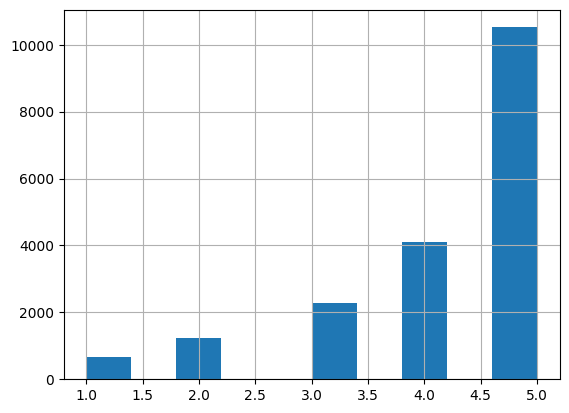

In [7]:
df_train['Rating'].hist()

In [8]:
tokenizer = TweetTokenizer()
stop_words = set(stopwords.words("english"))
keep_stop_words = ['not', 'no', 'against', 'above', 'below']
for word in keep_stop_words:
    stop_words.remove(word)
print('Removed stopwords:', stop_words)
lemmatizer = WordNetLemmatizer()

def tokenize_text(text: str):
    if (not isinstance(text, str)):
        raise ValueError(f"The text {text} isn't a string!")

    # Change 't to 'not'
    text = re.sub(r"n\'t", " not", text)
    
    text = text.lower()

    word_tokens = tokenizer.tokenize(text)

    filtered_words_tokens = [w for w in word_tokens if not w in stop_words]

    lemmatized_text = [lemmatizer.lemmatize(w) for w in filtered_words_tokens]
    
    return ' '.join(lemmatized_text)

Removed stopwords: {'the', 'than', 'been', 'did', 'y', 'can', 'm', 'mustn', "you'll", "mightn't", 'hers', 'after', "you've", 'what', 'him', 'are', 'didn', 'doing', 'when', 'ma', 'am', 'from', "that'll", 'is', 'but', 'they', 'up', 'i', 'isn', 'at', 'about', 'mightn', "aren't", 'hadn', 'had', 'couldn', 'aren', 'these', 'or', 'then', 'for', 'off', 'other', 'does', 'of', 'haven', 'd', 'themselves', 'while', 'them', 'those', "you're", 's', 'before', 'in', 'on', 'few', 'yourselves', 'during', 'very', 'with', 'both', "hadn't", 'where', 'its', 'so', 'should', "she's", 're', 't', 'needn', "didn't", "isn't", "wasn't", 'you', 'to', 'over', 'once', 'shouldn', "doesn't", 'yours', "it's", 'having', 'into', 'be', 'wasn', 'theirs', 'own', "needn't", 'being', 'ourselves', "mustn't", 'he', 'himself', 'she', 'his', 'out', "wouldn't", 'between', 'was', 'who', "shouldn't", 've', 'most', 'hasn', 'o', 'your', 'nor', 'our', "shan't", 'will', 'her', 'same', 'this', 'through', 'until', 'doesn', 'it', 'there', "

In [9]:
def get_tokenized_X(X):
    return [tokenize_text(text) for text in X]

In [10]:
def get_tfidf_vectorizer(X_train, ngram_range=(1, 1)):
    # settings inspired by https://www.linkedin.com/pulse/another-twitter-sentiment-analysis-python-part-5-tfidf-ricky-kim/
    # TODO consider options: max_df=0.9, min_df=2
    tfidf_vectorizer = TfidfVectorizer(ngram_range=ngram_range)
    tfidf_vectorizer.fit(get_tokenized_X(X_train))

    return tfidf_vectorizer

In [11]:
def get_vectorized_X(X, vectorizer):
    tokenized_X = get_tokenized_X(X)

    vectorized_X = vectorizer.transform(tokenized_X)

    return vectorized_X.toarray()

In [12]:
def get_df_tokenizer_applied(df, columns):
    df = df.copy()
    for column in columns:
        print(f"Applying tokenize_text() to column {column}")
        df[column] = df[column].apply(tokenize_text)
    return df

In [13]:
df_train_pp = get_df_tokenizer_applied(df_train, ['Title', 'Review Text'])
df_valid_pp = get_df_tokenizer_applied(df_valid, ['Title', 'Review Text'])
df_test_pp = get_df_tokenizer_applied(df_test, ['Title', 'Review Text'])

Applying tokenize_text() to column Title
Applying tokenize_text() to column Review Text
Applying tokenize_text() to column Title
Applying tokenize_text() to column Review Text
Applying tokenize_text() to column Title
Applying tokenize_text() to column Review Text


In [14]:
df_train_pp.head(3)

,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
0,767,33,,absolutely wonderful - silky sexy comfortable,4,1,0,Initmates,Intimate,Intimates
1,1080,34,,love dress ! sooo pretty . happened find store...,5,1,4,General,Dresses,Dresses
2,1049,50,favorite buy !,"love , love , love jumpsuit . fun , flirty , f...",5,1,0,General Petite,Bottoms,Pants


In [15]:
def get_ohe_for_one_df_column(df_column):
    ohe_column = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
    ohe_column.fit(df_column.to_numpy().reshape(-1, 1))
    return ohe_column

In [16]:
ohe_divisionname = get_ohe_for_one_df_column(df_train_pp['Division Name'])
ohe_departmentname = get_ohe_for_one_df_column(df_train_pp['Department Name'])
ohe_classname = get_ohe_for_one_df_column(df_train_pp['Class Name'])

In [17]:
def get_df_with_ohe_column(df, ohe_column_name, ohe):
    ohe_column_encoded = ohe.transform(df[ohe_column_name].to_numpy().reshape(-1, 1))

    ohe_df = pd.DataFrame(ohe_column_encoded.tolist(), columns=ohe.get_feature_names_out(input_features=[ohe_column_name]), dtype=int)
    # reset_index() is necessary here: https://stackoverflow.com/questions/50368145/pandas-concat-increases-number-of-rows
    # drop=True as well: https://stackoverflow.com/questions/12203901/pandas-crashes-on-repeated-dataframe-reset-index
    new_df = pd.concat([df.reset_index(drop=True), ohe_df], axis=1).drop([ohe_column_name], axis=1)

    return new_df

In [18]:
def get_df_with_ohe_columns(df):
    df = get_df_with_ohe_column(df, 'Division Name', ohe_divisionname)
    df = get_df_with_ohe_column(df, 'Department Name', ohe_departmentname)
    df = get_df_with_ohe_column(df, 'Class Name', ohe_classname)
    
    return df

In [19]:
df_train_ohe = get_df_with_ohe_columns(df_train_pp)
df_valid_ohe = get_df_with_ohe_columns(df_valid_pp)
df_test_ohe = get_df_with_ohe_columns(df_test_pp)
df_train_ohe.head(3)

,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name_,Division Name_General,Division Name_General Petite,...,Class Name_Legwear,Class Name_Lounge,Class Name_Outerwear,Class Name_Pants,Class Name_Shorts,Class Name_Skirts,Class Name_Sleep,Class Name_Sweaters,Class Name_Swim,Class Name_Trend
0,767,33,,absolutely wonderful - silky sexy comfortable,4,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1080,34,,love dress ! sooo pretty . happened find store...,5,1,4,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,1049,50,favorite buy !,"love , love , love jumpsuit . fun , flirty , f...",5,1,0,0,0,1,...,0,0,0,1,0,0,0,0,0,0


---

In [20]:
title_vectorizer = get_tfidf_vectorizer(df_train_ohe['Title'], (1, 3))
reviewtext_vectorizer = get_tfidf_vectorizer(df_train_ohe['Review Text'], (1, 3))

In [21]:
X_train_title = get_vectorized_X(df_train_ohe['Title'], title_vectorizer)
X_valid_title = get_vectorized_X(df_valid_ohe['Title'], title_vectorizer)

X_train_reviewtext = get_vectorized_X(df_train_ohe['Review Text'], reviewtext_vectorizer)
X_valid_reviewtext = get_vectorized_X(df_valid_ohe['Review Text'], reviewtext_vectorizer)

In [22]:
y_train_title = df_train_ohe['Rating'].tolist()
y_valid_title = df_valid_ohe['Rating'].tolist()

y_train_reviewtext = df_train_ohe['Rating'].tolist()
y_valid_reviewtext = df_valid_ohe['Rating'].tolist()

In [23]:
print(len(X_train_title), len(y_train_title))

print(len(X_valid_title), len(y_valid_title))

18790 18790
2348 2348


In [24]:
nb_title = MultinomialNB()
nb_title.fit(X_train_title, y_train_title)
y_pred_title = nb_title.predict(X_valid_title)
accuracy = accuracy_score(y_valid_title, y_pred_title)
print("Naive Bayes 'Title Sentiment' Accuracy: ", accuracy)

Naive Bayes 'Title Sentiment' Accuracy:  0.5924190800681431


In [25]:
logreg_title = LogisticRegression(random_state=random_state, solver="saga", max_iter=200)
logreg_title.fit(X_train_title, y_train_title)
y_pred_title = logreg_title.predict(X_valid_title)
accuracy = accuracy_score(y_valid_title, y_pred_title)
print("Logistic Regression 'Title Sentiment' Accuracy: ", accuracy)

Logistic Regression 'Title Sentiment' Accuracy:  0.6158432708688245


In [26]:
nb_reviewtext = MultinomialNB()
nb_reviewtext.fit(X_train_reviewtext, y_train_reviewtext)
y_pred_reviewtext = nb_reviewtext.predict(X_valid_reviewtext)
accuracy = accuracy_score(y_valid_reviewtext, y_pred_reviewtext)
print("Naive Bayes 'Review Text' Accuracy: ", accuracy)

Naive Bayes 'Review Text' Accuracy:  0.5549403747870528


---

In [27]:
# def get_unique_values(df: pd.Series):
#     return df.unique().tolist()

def preprocess_df(df: pd.DataFrame):
    vectorized_title = title_vectorizer.transform(df['Title']).toarray()
    df['Title Sentiment'] = logreg_title.predict(vectorized_title)
    df.drop(['Title'], axis=1, inplace=True)

    vectorized_reviewtext = reviewtext_vectorizer.transform(df['Review Text']).toarray()
    df['Review Text Sentiment'] = nb_reviewtext.predict(vectorized_reviewtext)
    df.drop(['Review Text'], axis=1, inplace=True)

    return df

In [28]:
df_train_final = preprocess_df(df_train_ohe)
df_valid_final = preprocess_df(df_valid_ohe)
df_test_final = preprocess_df(df_test_ohe)

In [29]:
df_train_final.head(3)

,Clothing ID,Age,Rating,Recommended IND,Positive Feedback Count,Division Name_,Division Name_General,Division Name_General Petite,Division Name_Initmates,Department Name_,...,Class Name_Outerwear,Class Name_Pants,Class Name_Shorts,Class Name_Skirts,Class Name_Sleep,Class Name_Sweaters,Class Name_Swim,Class Name_Trend,Title Sentiment,Review Text Sentiment
0,767,33,4,1,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,5,5
1,1080,34,5,1,4,0,1,0,0,0,...,0,0,0,0,0,0,0,0,5,5
2,1049,50,5,1,0,0,0,1,0,0,...,0,1,0,0,0,0,0,0,5,5


In [30]:
df_valid_final.head(3)

,Clothing ID,Age,Rating,Recommended IND,Positive Feedback Count,Division Name_,Division Name_General,Division Name_General Petite,Division Name_Initmates,Department Name_,...,Class Name_Outerwear,Class Name_Pants,Class Name_Shorts,Class Name_Skirts,Class Name_Sleep,Class Name_Sweaters,Class Name_Swim,Class Name_Trend,Title Sentiment,Review Text Sentiment
0,1077,60,3,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,3,5
1,858,39,4,1,4,0,0,1,0,0,...,0,0,0,0,0,0,0,0,5,5
2,1077,24,5,1,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,5,5


In [31]:
y_train = df_train_final['Rating'].values
y_train

array([4, 5, 5, ..., 3, 3, 5])

In [32]:
X_train = df_train_final.drop(['Rating'], axis=1).values
X_train

array([[ 767,   33,    1, ...,    0,    5,    5],
       [1080,   34,    1, ...,    0,    5,    5],
       [1049,   50,    1, ...,    0,    5,    5],
       ...,
       [ 862,   48,    1, ...,    0,    3,    5],
       [1084,   28,    1, ...,    0,    5,    5],
       [1104,   52,    1, ...,    0,    5,    5]])

In [33]:
y_valid = df_valid_final['Rating'].values

In [34]:
X_valid = df_valid_final.drop(['Rating'], axis=1).values

In [35]:
# rf_tab = RandomForestClassifier(random_state=random_state, n_estimators=1000) # accuracy: 0.6490630323679727
# rf_tab = RandomForestClassifier(random_state=random_state, n_estimators=5000) # accuracy: 0.6507666098807495
rf_tab = RandomForestClassifier(random_state=random_state, n_estimators=10000)
rf_tab.fit(X_train, y_train)
y_preds = rf_tab.predict(X_valid)
rf_tab_accuracy = accuracy_score(y_valid, y_preds)
print(f"Random Forest tabular accuracy: {rf_tab_accuracy}")

Random Forest tabular accuracy: 0.6060477001703578


In [36]:
# logreg_tab = LogisticRegression(random_state=random_state, solver="saga", max_iter=10000) # accuracy: 0.6416065911431514
logreg_tab = LogisticRegression(random_state=random_state, solver="lbfgs", max_iter=10000) # accuracy: 0.646755921730175
logreg_tab.fit(X_train, y_train)
y_preds = logreg_tab.predict(X_valid)
logreg_tab_accuracy = accuracy_score(y_valid, y_preds)
print(f"Logistic Regression tabular accuracy: {logreg_tab_accuracy}")

Logistic Regression tabular accuracy: 0.6482112436115843


In [37]:
# gbt_tab = GradientBoostingClassifier(random_state=random_state, n_estimators=5000) # accuracy: 0.610732538330494
# gbt_tab = GradientBoostingClassifier(random_state=random_state, n_estimators=1000) # accuracy: 0.6401192504258943
gbt_tab = GradientBoostingClassifier(random_state=random_state, n_estimators=500)
gbt_tab.fit(X_train, y_train)
y_preds = gbt_tab.predict(X_valid)
gbt_tab_accuracy = accuracy_score(y_valid, y_preds)
print(f"Gradient Boosting tabular accuracy: {gbt_tab_accuracy}")

Gradient Boosting tabular accuracy: 0.6499148211243612


In [38]:
le = LabelEncoder()
le.fit(y_train)
y_train_trans = le.transform(y_train)
y_valid_trans = le.transform(y_valid)

bst_tab = XGBClassifier(n_estimators=9, max_depth=2, learning_rate=.9, objective='multi:softmax')
bst_tab.fit(X_train, y_train_trans)
y_preds = bst_tab.predict(X_valid)
bst_tab_accuracy = accuracy_score(y_valid_trans, y_preds)
print(f"XGBoost tabular accuracy: {bst_tab_accuracy}")

XGBoost tabular accuracy: 0.6524701873935264
